# Switch Array

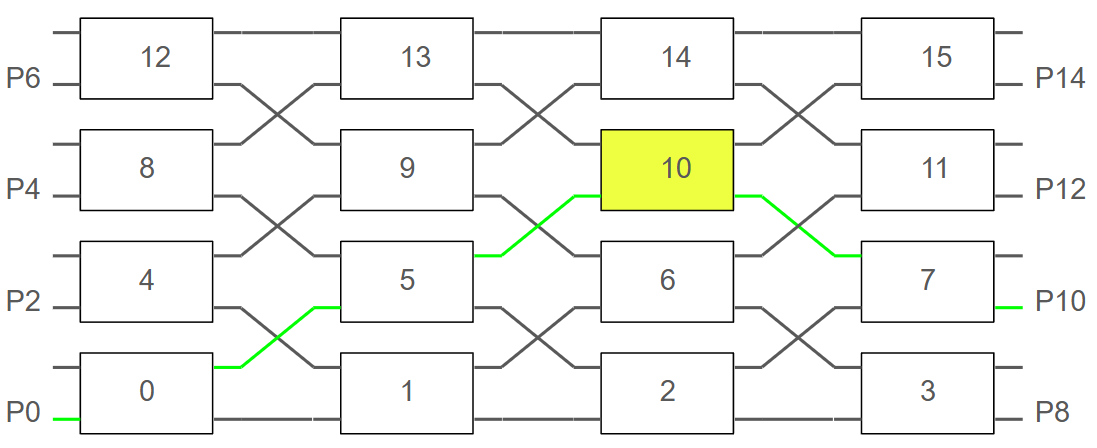


In this notebook, we create a switch array inspired by the work of Suzuki *et al.* [1], which demonstrated a 32×32 silicon photonic switch with ultra-low insertion loss and power-efficient operation. Their design utilizes a high-Δ silica planar lightwave circuit (PLC) platform to achieve compact and low-crosstalk routing. The switch architecture enables scalable integration of photonic components with precise routing of optical signals across multiple paths. 

We implement a scalable version of such a switch using an array of unit cells, where each unit cell can be interconnected via parameterized routing. Our implementation mimics the concept of highly efficient and integrated photonic switching fabrics proposed in [1].

This architecture is particularly advantageous when using p-i-n junctions for fast switching. In such cases, carrier injection through the junction introduces additional loss, which can increase insertion loss, degrade uniformity, and cause crosstalk. However, in this architecture, only one Mach–Zehnder Interferometer is active per switching configuration, resulting in consistently low insertion loss and improved signal uniformity across the array [2].


**References**

1. Suzuki, Keijiro, *et al*. "Low-insertion-loss and power-efficient 32×32 silicon photonics switch with extremely high-Δ silica PLC connector." *Journal of Lightwave Technology* 2019 37 (1), 116-122, doi: [10.1109/JLT.2018.2867575](https://doi.org/10.1109/JLT.2018.2867575).
2. Konoike, Ryotaro, Keijiro Suzuki, and Kazuhiro Ikeda. "Path-independent insertion loss 8× 8 silicon photonics switch with nanosecond-order switching time." *Journal of Lightwave Technology* 2023 41 (3), 865-870, doi: [10.1364/JLT.41.000865](https://doi.org/10.1364/JLT.41.000865)
3. Y. Ma *et al*., “Ultralow loss single layer submicron silicon waveguide crossing for SOI optical interconnect,” *Opt Express*, 2023 21 (24), 29374–29382, doi: [10.1364/OE.21.029374](https://doi.org/10.1364/OE.21.029374)



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import photonforge as pf
import siepic_forge as siepic_pdk
import tidy3d as td
from photonforge.live_viewer import LiveViewer

viewer = LiveViewer(port=5004)

Starting live viewer at http://localhost:5004


We start by setting up the simulation environment using the [SiEPIC OpenEBL PDK](https://siepic.ca/openebl/) platform. This includes defining waveguide parameters, default simulation settings, and wavelength ranges. The technology is configured to use Tidy3D for simulating components such as bends and S-bends. 

To focus the simulation, we define a narrow wavelength sweep around 1.55 µm—representing the telecom C-band—and convert this wavelength range to corresponding optical frequencies for use in frequency-domain simulations.



In [2]:
bend_radius = 10  # default bend radius in microns
wg_width = 0.43  # waveguide width in microns
width_nm = int(wg_width * 1e3)

# Load SiEPIC OpenEBL technology PDK
tech = siepic_pdk.ebeam()

# Set the default technology to SiEPIC OpenEBL
pf.config.default_technology = tech

# Set Tidy3D logging level to suppress non-critical messages
td.config.logging_level = "ERROR"

# Configure default parameters for photonic components
pf.config.default_kwargs = {
    "bend": {"active_model": "Tidy3D"},  # set simulation model for bends
    "s_bend": {"active_model": "Tidy3D"},  # set simulation model for S-bends
    "radius": bend_radius,  # default bend radius
    "euler_fraction": 0.5,  # Euler bend fraction
}

# Define wavelength range for the simulation
wavelengths = np.linspace(1.53, 1.57, 51)

lambda_0 = 1.55  # central wavelength in microns

# Convert wavelengths to frequencies (Hz)
frequencies = pf.C_0 / wavelengths

Additionally, we configure the port specification to use a 430 nm–wide waveguide—matching the design in [1]—and integrate this port into the technology.

In [3]:
# copy & tweak the existing 500 nm TE port
port_spec = tech.ports["TE_1550_500"].copy()
port_spec.path_profiles = [(wg_width, 0.0, (1, 0))]

# build your new port name & description from wg_width
port_name = f"TE_1550_{width_nm}"
port_spec.description = f"Strip TE 1550 nm, w={width_nm} nm"

# register it
tech.add_port(port_name, port_spec)

Name: SiEPIC EBeam
Version: 0.4.32

Layers:
        Name          Layer    Description    Color    Pattern
--------------------------------------------------------------
Si                    (1, 0)   Waveguides   #ff80a818     \\  
PinRec               (1, 10)   SiEPIC       #00408018     /   
PinRecM              (1, 11)   SiEPIC       #00408018     /   
Si_Litho193nm        (1, 69)   Waveguides   #cc80a818     \   
Waveguide            (1, 99)   Waveguides   #ff80a818     \   
Si slab               (2, 0)   Waveguides   #80a8ff18     /   
SiN                   (4, 0)   Waveguides   #a6cee318     \\  
Oxide open (to BOX)   (6, 0)   Waveguides   #ffae0018     \   
Text                 (10, 0)                #0000ff18     \   
M1_heater            (11, 0)   Metal        #ebc63418     xx  
M2_router            (12, 0)   Metal        #90857018     xx  
M_Open               (13, 0)   Metal        #3471eb18     xx  
Si N                 (20, 0)   Doping       #7000ff18     \\  
Si N++               (24, 0)   Doping       #0000ff18     :   
VC                   (40, 0)   Metal        #3a027f18     xx  
DevRec               (68, 0)   SiEPIC       #00408018   hollow
FbrTgt               (81, 0)   SiEPIC       #00408018     /   
FloorPlan            (99, 0)   Misc         #8000ff18   hollow
SEM                  (200, 0)  Misc         #ff00ff18     \   
Deep Trench          (201, 0)  Misc         #c0c0c018   solid 
Keep out             (202, 0)  Misc         #a0a0c018     //  
Isolation Trench     (203, 0)  Misc         #c0c0c018   solid 
Dicing               (210, 0)  Misc         #a0a0c018   solid 
Chip design area     (290, 0)  Misc         #80005718   hollow
FDTD                 (733, 0)  SiEPIC       #80005718   hollow
BlackBox             (998, 0)  SiEPIC       #00408018   solid 
Errors               (999, 0)  SiEPIC       #00008018     /   

Extrusion Specs:
#                Mask                Limits (μm)  Sidewal (°)        Opt. Medium                   Elec. Medium          
-------------------------------------------------------------------------------------------------------------------------
0  'Oxide open (to BOX)'                0, inf         0       Medium(permittivity=1.0)  Medium(permittivity=1.0)        
1  'Si'                                0, 0.22         0       cSi_Li1993_293K           Si                              
2  'Si slab'                           0, 0.09         0       cSi_Li1993_293K           Si                              
3  'SiN'                                0, 0.4         0       Si3N4_Luke2015_PMLStable  Si3N4                           
4  'M2_router' + 'M1_heater'          2.42, 2.62       0       W_Werner2009              LossyMetalMedium(conductivity=1…
5  'M2_router'                        2.62, 3.02       0       Au_JohnsonChristy1972     LossyMetalMedium(conductivity=1…
6  'M_Open'                           3.02, inf        0       Medium(permittivity=1.0)  Medium(permittivity=1.0)        
7  'Deep Trench' + 'Isolation Tren…   -inf, inf        0       Medium(permittivity=1.0)  Medium(permittivity=1.0)        

Ports:
        Name         Classification            Description             Width (μm)  Limits (μm)  Radius (μm)    Modes     Target n_eff         Path profiles (μm)         Voltage path  Current path
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
MM_SiN_TE_1550_3000     optical      Multimode SiN Strip TE 1550 nm,…      8        -2.5, 2.9        0           7           2.1       'SiN': 3                                                    
MM_TE_1550_2000         optical      Multimode Strip TE 1550 nm, w=2…      6         -2, 2.22        0           12          3.5       'Si': 2                                                     
MM_TE_1550_3000         optical      Multimode Strip TE 1550 nm, w=3…      6         -2, 2.22      

We examine the port’s field profile to ensure it decays sufficiently at its boundaries; otherwise, we would adjust the port’s `width` and `limits`. In this case, the field has already decayed adequately.


Loading cached simulation from .tidy3d/pf_cache/WU5/ms_info-M3I4MX4VU3YGUGEH7VIHTT6DBHER6UE3N64OFZTP5WMPBUMDXOQA.json.


Progress: 100%


<Axes: title={'center': 'cross section at x=0.00 (μm)'}, xlabel='y (μm)', ylabel='z (μm)'>

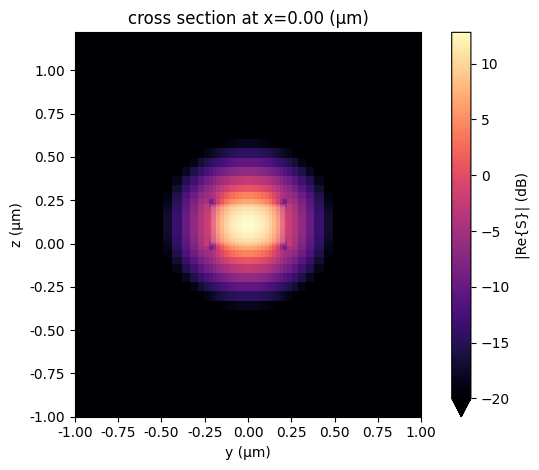

In [4]:
mode_solver = pf.port_modes(port_spec, [pf.C_0 / lambda_0])
mode_solver.plot_field("S", mode_index=0, scale="dB", vmin=-20, robust=False)

## Angled Adiabatic Waveguide Crossing

We define a 4-arm angled adiabatic waveguide crossing with smooth cubic taper profiles, inspired by the device presented in [3]. This structure has been designed to minimize insertion loss and crosstalk by employing gradually varying widths along the propagation direction. The crossing is symmetrically constructed using four identical arms created through geometric operations.

The crossing incorporates adiabatic tapers formed via cubic spline interpolation, which ensures smooth transitions between waveguide widths. The component is constructed in compliance with symmetry conditions and is modeled using Tidy3D with specified port symmetries for reducing simulation costs.


In [5]:
from scipy.interpolate import make_interp_spline

default_widths = (
    0.5,
    0.6,
    0.95,
    1.32,
    1.44,
    1.46,
    1.466,
    1.52,
    1.58,
    1.62,
    1.76,
    2.15,
    0.5,
)


@pf.parametric_component(name_prefix="CROSSING")
def angled_adiabatic_crossing(
    *,
    port_spec="TE_1550_500",
    arm_length=4.5,
    widths=default_widths,
    radius=bend_radius,
    num_points=100,
):
    """
    Create a 4-arm adiabatic crossing with smooth cubic taper profiles.

    Parameters:
        port_spec (str or PortSpec): Input/output port specification name or object.
        arm_length (float): Length of the main arm (µm).
        widths (Sequence[float]): Target waveguide widths (µm) along each arm.
        radius (float): Radius of the 45-deg arcs (µm).

    Returns:
        A crossing component.
    """
    if isinstance(port_spec, str):
        port_spec = pf.config.default_technology.ports[port_spec]

    wg_width, _ = port_spec.path_profile_for("Si")  # extract initial waveguide width

    # Calculate port locations based on input dimensions (projected to the 45° axes)
    projected_arm_length = arm_length * 2**-0.5
    arc_y = radius * 2**-0.5
    arc_x = radius - arc_y
    # Snap port coordinates to the grid to avoid gaps/overlaps
    xp = pf.snap_to_grid(projected_arm_length + arc_x)
    yp = pf.snap_to_grid(projected_arm_length + arc_y)

    # Create cubic spline interpolation for widths
    coords = np.linspace(0, projected_arm_length, len(widths))
    # Reverse widths, because we're starting from 0 at the center of the cross
    spline = make_interp_spline(coords, widths[::-1], k=3)

    # Pre-compute widths and positions from the interpolation
    coords = np.linspace(projected_arm_length, 0, num_points)
    widths = spline(coords)

    arm1 = pf.Path((xp, yp), wg_width)
    arm1.arc(
        0,
        -45,
        radius,
        width=(widths[0], "smooth"),
        endpoint=(projected_arm_length, projected_arm_length),
    )
    for x, w in zip(coords[1:], widths[1:]):
        arm1.segment((x, x), w)

    arm2 = arm1.copy().mirror()
    arm3 = arm1.copy().rotate(180)
    arm4 = arm2.copy().rotate(180)

    c = pf.Component()
    c.add("Si", *pf.boolean([arm1, arm2], [arm3, arm4], "+"))

    # Add ports
    c.add_port(c.detect_ports([port_spec]))
    assert len(c.ports) == 4, "Port detection failed: expected exactly 4 ports."

    # Add Tidy3D simulation model with symmetry conditions
    c.add_model(
        pf.Tidy3DModel(
            port_symmetries=[
                ("P1", "P0", "P3", "P2"),  # symmetry about x-axis
                ("P2", "P3", "P0", "P1"),  # symmetry about y-axis
                ("P3", "P2", "P1", "P0"),  # inversion symmetry
            ],
        ),
        "Tidy3DModel",
    )
    return c


crossing = angled_adiabatic_crossing(port_spec=port_spec)
viewer(crossing)


To evaluate the optical performance of the angled adiabatic crossing, we compute its scattering matrix (S-matrix) over the defined wavelength range. The S-matrix characterizes the power transmission and reflection between each pair of ports. We then visualize the resulting S-matrix to inspect insertion loss and crosstalk across the device.


Loading cached simulation from .tidy3d/pf_cache/5DN/fdtd_info-GVBIH6453R4AA5JDRTAE56JZ5D2XPEDJC2MYW6URCGRINGIJLFOA.json.
Progress: 100% 


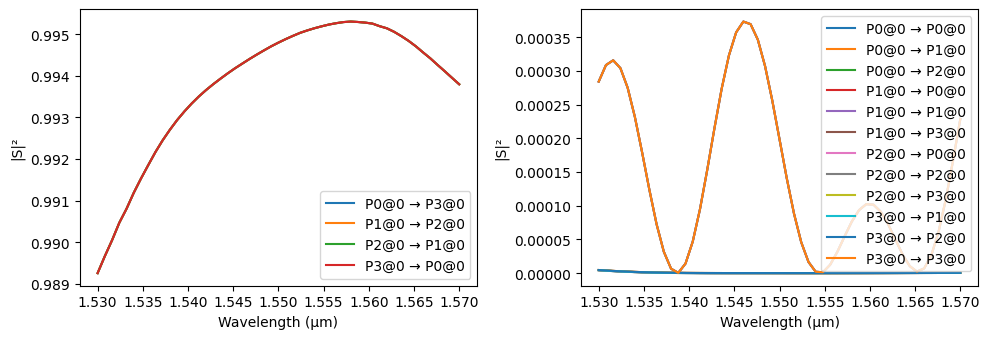

In [6]:
# Compute the scattering matrix of the crossing over the frequency range
s_matrix_crossing = crossing.s_matrix(frequencies)

# Plot the magnitude of the S-matrix to evaluate transmission and crosstalk
_ = pf.plot_s_matrix(s_matrix_crossing)

## Directional Coupler

We define a dual-ring directional directional coupler to be used in the switch array. The design includes two curved waveguides with a specified coupling distance and coupling length. The radius and Euler bend fraction are set to ensure adiabatic transitions. To facilitate efficient simulation with Tidy3D, we explicitly define the port symmetries, ensuring accurate modeling of the device behavior.


In [7]:
# Define a dual-ring directional coupler with specified geometry and waveguide spacing
dc_coupler = pf.parametric.dual_ring_coupler(
    port_spec=port_spec,  # use predefined port specification
    coupling_distance=0.75,  # gap between the coupled waveguides (µm)
    radius=5,  # bend radius (µm)
    euler_fraction=0.5,  # fraction of Euler bend
    coupling_length=20.8,  # coupling region length (µm)
)

# Define symmetries for accurate simulation with Tidy3D
dc_coupler.models["Tidy3D"].port_symmetries = [
    ("P1", "P0", "P3", "P2"),  # x-axis reflection
    ("P2", "P3", "P0", "P1"),  # y-axis reflection
    ("P3", "P2", "P1", "P0"),  # inversion symmetry
]

dc_length, dc_width = dc_coupler.size()

viewer(dc_coupler)  # Display the coupler

We simulate the dual-ring coupler to extract its S-matrix across the defined frequency range.

Loading cached simulation from .tidy3d/pf_cache/CDO/fdtd_info-TJGI4GJPUUTRV4OFMOIAGRW7W62NVMB42UM5ZM6ZH5ZQQS7ZG2HA.json.
Progress: 100% 


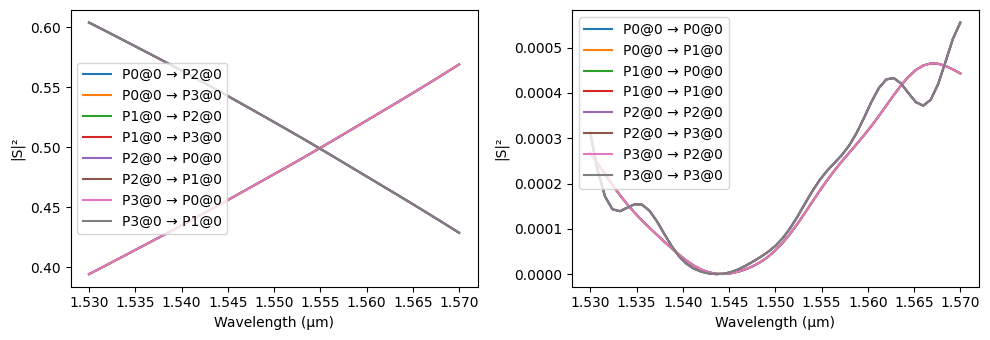

In [8]:
# Compute the S-matrix of the dual-ring coupler over the specified frequencies
s_matrix_dc = dc_coupler.s_matrix(frequencies)

# Plot the S-matrix to visualize power transmission and coupling behavior
_ = pf.plot_s_matrix(s_matrix_dc)

## Thermal Phase Shifter

We model a straight waveguide to serve as a thermal phase shifter. To account for propagation loss, we compute the imaginary part of the refractive index from a specified loss value in dB/cm. Using mode solving, we extract the complex effective index across the wavelength range.

We then define a function that maps applied voltage to a change in the real part of the refractive index, simulating the thermo-optic effect. This function enables modeling phase modulation based on input voltage. Finally, we assign the zero-voltage thermal model as the default waveguide model in the phase shifter component.


In [9]:
wg_length = 70  # length of the straight waveguide in microns
alpha = 3  # propagation loss in dB/cm

# Calculate imaginary part of refractive index from loss
kappa = (alpha * wavelengths * 1e-4 * np.log(10)) / (40 * np.pi)

# Solve for waveguide modes to obtain complex effective index
mode_solver = pf.port_modes(port=port_spec, frequencies=pf.C_0 / wavelengths)
n_complex = mode_solver.data.n_complex.values.T + 1j * kappa  # include loss in index

# Create straight waveguide to model thermal phase shifter
phase_shifter = pf.parametric.straight(
    port_spec=port_spec, length=wg_length, name="Phase Shifter"
)
wg = pf.parametric.straight(port_spec=port_spec, length=wg_length, name="wg")
wg_model = pf.WaveguideModel(n_complex=n_complex)
wg.add_model(wg_model)  # assign loss model to auxiliary waveguide


# Define voltage-dependent refractive index model for thermal tuning
def index(voltage, resistance=0.9, coefficient=1e-3):
    """
    Calculate complex refractive index as a function of applied voltage.

    Parameters:
        voltage (float): Applied voltage (V).
        resistance (float): Heater resistance (Ω).
        coefficient (float): Proportionality constant.

    Returns:
        np.ndarray: Complex refractive index array.
    """
    dn = coefficient * voltage**2 / resistance  # thermo-optic phase shift
    return n_complex + dn


# Set the default waveguide model at 0 V as the initial thermal model
thermal_model = pf.WaveguideModel(n_complex=index(0))

# Add thermal model to phase shifter component
_ = phase_shifter.add_model(thermal_model, "Waveguide")

Loading cached simulation from .tidy3d/pf_cache/NSH/ms_info-SD4LCIFGTE7K3N3O5PPLSVEAUU4ZE2YZ4NRUCTXJ3CQX2NSJACVQ.json.


Progress: 100%


## Tunable Mach–Zehnder Interferometer (MZI)

We construct a tunable Mach–Zehnder Interferometer using a netlist-based approach. The MZI consists of two directional couplers and two thermal phase shifters placed in each interferometer arm. Routing is done automatically between connected ports, ensuring proper alignment and spacing.

By configuring the thermal phase shifters with voltage-dependent refractive index models, this MZI design enables dynamic phase control and interference tuning, which are essential for applications like modulation and switching in photonic circuits.


In [10]:
netlist_mzi = {
    "name": "Tunable MZI",  # name of the component
    "instances": {
        "dc0": dc_coupler,  # first directional coupler
        "ps0": {
            "component": phase_shifter,
            "origin": (dc_length + bend_radius, -wg_length / 2 - dc_width),  # lower arm
        },
        "ps1": {
            "component": phase_shifter,
            "origin": (dc_length + bend_radius, wg_length / 2),  # upper arm
        },
        "dc1": {
            "component": dc_coupler,
            "origin": (
                2 * dc_length + 2 * bend_radius + wg_length,
                0,
            ),  # second coupler
        },
    },
    # Define waveguide routes between instances
    "routes": [
        (("dc0", "P2"), ("ps0", "P0"), pf.parametric.route),
        (("dc0", "P3"), ("ps1", "P0"), pf.parametric.route),
        (("dc1", "P1"), ("ps1", "P1"), pf.parametric.route),
        (("dc1", "P0"), ("ps0", "P1"), pf.parametric.route),
    ],
    # Expose external ports
    "ports": [("dc0", "P0"), ("dc0", "P1"), ("dc1", "P2"), ("dc1", "P3")],
    # Assign simulation model for the full circuit
    "models": [(pf.CircuitModel(), "Circuit")],
}

# Create the MZI component from the defined netlist
mzi = pf.component_from_netlist(netlist_mzi)

# Visualize the MZI
viewer(mzi)

We evaluate the voltage-dependent behavior of the Mach–Zehnder Interferometer by sweeping the applied voltage on one of its thermal phase shifters. For each voltage, we update the refractive index model accordingly and compute the S-matrix to extract transmission values at the central wavelength.

This analysis identifies the "bar" and "cross" states of the MZI—key operational modes used in optical switching and modulation. We visualize how power routing between output ports changes with applied voltage and mark the voltages corresponding to the bar and cross states on the plot.


Loading cached simulation from .tidy3d/pf_cache/VUF/ms_info-3CBGFY4J5L5S2Y23SMNRVE53SVSPHKAOPRHCDLW5CVDUTAD6NCAQ.json.
Loading cached simulation from .tidy3d/pf_cache/5H4/ms_info-Z766DH34N7S2ZFWK5JQTOL3LAMLVSG25KFSCRXVM2635NYIY2HMQ.json.
Loading cached simulation from .tidy3d/pf_cache/QL2/ms_info-RTU4ACEWWQ6WIRY3L52WTT3QW4YYULJ6GZZ7L2MPQTO4F7OIU3AQ.json.
Loading cached simulation from .tidy3d/pf_cache/ZPI/ms_info-DBWVGF4553OTWDIOJAISXUPWWNEE7QD5HS4DVBPIZJDK6ITAHCLQ.json.


Loading cached simulation from .tidy3d/pf_cache/BLD/fdtd_info-HXZDAXVTSJOMUBCSUM74DYMB4JDPTPLXYK3DYHXJVH7JKMYCY5CQ.json.
Loading cached simulation from .tidy3d/pf_cache/Q4X/fdtd_info-SZX57UHS6QTON2LB6ZNIV2LTSWFYSVAEUY3G63KLIB2UUFDYAHDA.json.


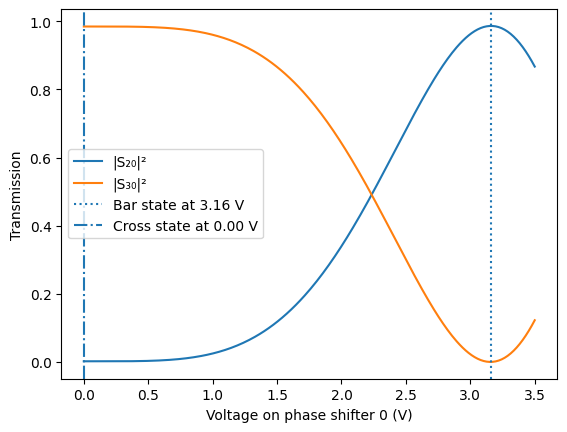

In [11]:
voltages = np.linspace(0, 3.5, 301)  # voltage sweep range

# Initialize array to store transmission values at both output ports
transmission = np.zeros((voltages.size, 2))

m = len(wavelengths) // 2  # index of central wavelength

# Loop over voltage values and compute updated transmission
for i, v in enumerate(voltages):
    updates = {
        ("Phase Shifter", 0): {
            "model_updates": {"n_complex": index(v)}
        },  # apply voltage
        ("Phase Shifter", 1): {"model_updates": {"n_complex": index(0)}},  # keep fixed
    }

    # Compute S-matrix for current voltage configuration
    s = mzi.s_matrix(
        pf.C_0 / wavelengths, model_kwargs={"updates": updates}, show_progress=False
    )

    # Extract and store transmission magnitude squared for each output
    transmission[i, 0] = np.abs(s[("P0@0", "P2@0")][m]) ** 2
    transmission[i, 1] = np.abs(s[("P0@0", "P3@0")][m]) ** 2

# Find voltage corresponding to bar state (minimum output at port 3)
idx_zero = np.argmin(np.abs(transmission[:, 1]))
v_bar = voltages[idx_zero]  # bar state voltage

v_cross = 0  # cross state defined at 0 volts

# Plot transmission curves vs voltage
plt.plot(voltages, transmission[:, 0], label="|S₂₀|²")  # transmission to port 2
plt.plot(voltages, transmission[:, 1], label="|S₃₀|²")  # transmission to port 3
plt.axvline(v_bar, linestyle=":", label=f"Bar state at {v_bar:.2f} V")
plt.axvline(v_cross, linestyle="-.", label=f"Cross state at {v_cross:.2f} V")
plt.xlabel("Voltage on phase shifter 0 (V)")
plt.ylabel("Transmission")
plt.legend()

plt.show()  # display plot

## Tunable Unit Cell
### Custom Waveguide Bends and S-Bends

We define three types of curved waveguide components to manage routing in this circuit: an S-bend, an extended bend, and a long extended bend. Each path is constructed using arcs and linear segments to ensure smooth transitions and maintain consistent mode propagation.

All components are assigned appropriate ports and use the same complex waveguide model to include propagation loss. These elements will be used in routing scenarios where geometric constraints or thermal tuning paths require customized bending profiles.


In [12]:
# Define an S-bend using arcs and diagonal segment
s_bend_path = (
    pf.Path((0, 0), wg_width)
    .arc(180, 135)  # create initial arc
    .segment(
        (wg_length / 2 - bend_radius, wg_length / 2 - bend_radius),
        relative=True,
    )  # diagonal segment
    .arc(-45, 0)  # final arc to complete S shape
)

# Create S-bend component and assign waveguide model
s_bend = pf.Component("Custom S Bend").add("Si", s_bend_path)
s_bend.add_port(s_bend.detect_ports([port_spec]))
_ = s_bend.add_model(wg_model, "Waveguide")

# Define a 90-degree bend with extended diagonal segment
bend_path = (
    pf.Path((0, 0), wg_width)
    .arc(0, 45)  # initial arc
    .segment(
        (-wg_length / 2 + bend_radius, wg_length / 2 - bend_radius),
        relative=True,
    )  # diagonal segment
    .arc(45, 90)  # final arc to complete the bend
)

# Create extended bend component and assign waveguide model
bend = pf.Component("Extended Bend").add("Si", bend_path)
bend.add_port(bend.detect_ports([port_spec]))
_ = bend.add_model(wg_model, "Waveguide")

# Define a longer bend with extended length and tighter arc overlap
long_bend_length = (
    wg_length - bend_radius / 2 - 2 * wg_width
)  # calculate diagonal segment length
long_bend_path = (
    pf.Path((0, 0), wg_width)
    .arc(0, 45)  # initial arc
    .segment(
        (-long_bend_length, long_bend_length),
        relative=True,
    )  # long diagonal segment
    .arc(45, 90)  # final arc
)

# Create long bend component and assign waveguide model
long_bend = pf.Component("Long Extended Bend").add("Si", long_bend_path)
long_bend.add_port(long_bend.detect_ports([port_spec]))
_ = long_bend.add_model(wg_model, "Waveguide")

### Constructing a Tunable Unit Cell

We create a tunable unit cell composed of various photonic building blocks: an MZI for modulation, bends, S-bends and waveguides for connectivity. The structure is assembled using a netlist that explicitly defines all component instances, their spatial transformations, and port-level connections.

This modular unit cell forms the basis for scalable switch arrays and can be easily replicated to build larger photonic networks. A circuit model is attached to enable end-to-end simulation of its behavior under voltage-controlled tuning.


In [13]:
netlist_uc = {
    "name": "Unit Cell",
    "instances": {
        "b0": {"component": s_bend, "x_reflection": True},
        "wg0": wg,
        "mzi": mzi,
        "wg1": wg,
        "b1": s_bend,
        "b2": {"component": bend, "x_reflection": True},
        "b3": bend,
        "wg2": wg,
        "wg3": wg,
        "lb0": long_bend,
        "lb1": {"component": long_bend, "x_reflection": True},
    },
    # Explicitly define connections between component ports
    "connections": [
        (("wg0", "P0"), ("b0", "P1")),
        (("mzi", "P1"), ("wg0", "P1")),
        (("wg1", "P0"), ("mzi", "P0")),
        (("b1", "P0"), ("wg1", "P1")),
        (("b2", "P0"), ("mzi", "P2")),
        (("b3", "P0"), ("mzi", "P3")),
        (("wg2", "P0"), ("b2", "P1")),
        (("wg3", "P0"), ("b3", "P1")),
        (("lb0", "P0"), ("wg2", "P1")),
        (("lb1", "P0"), ("wg3", "P1")),
    ],
    # Define external ports of the tunable unit
    "ports": [("b1", "P1"), ("b0", "P0"), ("lb0", "P1"), ("lb1", "P1")],
    # Assign circuit model to the assembled unit
    "models": [(pf.CircuitModel(), "Circuit")],
}

# Create a photonic component from the defined netlist
unit_cell = pf.component_from_netlist(netlist_uc)

# Visualize the assembled tunable unit
viewer(unit_cell)

## Creating an $n \times n$ Switch Array

We define a function to construct a tunable optical switch array by tiling unit cells in an $n \times n$ grid. Each 2×2 block of cells includes a crossing element at the center for inter-cell routing. The structure is built with proper alignment and spacing based on the bend radius and unit dimensions.

Routing is added between adjacent units along the top and bottom rows, and internal connections are made through the crossings. Ports on the array’s edges are exposed for external connectivity, and a circuit model is attached to the entire structure for simulation purposes.

This modular architecture enables scalable switching networks for programmable photonic systems.


In [14]:
def make_switch_array(n, unit_cell, crossing):
    """
    Build an n×n grid of `unit_cell` with crossings in each 2×2 cell block,
    edge‐row interconnects, port exports, and a CircuitModel.

    Parameters
    ----------
    n : int
        Number of cells along each side.
    unit_cell : pf.Component
        The base cell to tile.
    crossing : pf.Component
        The crossing element to place at each 2×2 center.

    Returns
    -------
    pf.Component
        A top‐level Component containing the full array.
    """
    # Create top‐level switch array container
    switch_array = pf.Component("Switch Array")

    port_width = unit_cell.ports["P0"].spec.width  # waveguide width for spacing

    # Compute horizontal and vertical pitches between unit cells
    px = unit_cell.size()[0] + crossing.size()[0] - 2 * port_width
    py = unit_cell.size()[1] + 1.1 * crossing.size()[1]

    # Instantiate and place unit cells in n×n grid
    cells = []
    for i in range(n):
        row = []
        for j in range(n):
            u = switch_array.add_reference(unit_cell)
            u.translate((j * px, i * py))
            row.append(u)
        cells.append(row)

    # Route between adjacent unit cells in the first row (P2→P0)
    for j in range(n - 1):
        switch_array.add_reference(
            pf.parametric.route(
                port1=cells[0][j]["P2"],
                port2=cells[0][j + 1]["P0"],
            )
        )

    # Route between adjacent unit cells in the last row (P3→P1)
    for j in range(n - 1):
        switch_array.add_reference(
            pf.parametric.route(port1=cells[-1][j]["P3"], port2=cells[-1][j + 1]["P1"])
        )

    # Insert crossings and route 2×2 internal blocks
    for i in range(n - 1):
        for j in range(n - 1):
            u0 = cells[i][j]  # lower-left unit
            u1 = cells[i][j + 1]  # lower-right unit
            u2 = cells[i + 1][j]  # upper-left unit
            u3 = cells[i + 1][j + 1]  # upper-right unit

            c = switch_array.add_reference(crossing)
            c.x_mid = (u0.x_mid + u3.x_mid) / 2  # center the crossing
            c.y_mid = (u0.y_mid + u3.y_mid) / 2

            # Connect each neighboring unit cell port into the crossing
            switch_array.add_reference(
                pf.parametric.route(port1=u0["P3"], port2=c["P0"])
            )
            switch_array.add_reference(
                pf.parametric.route(port1=u1["P1"], port2=c["P2"])
            )
            switch_array.add_reference(
                pf.parametric.route(port1=u2["P2"], port2=c["P1"])
            )
            switch_array.add_reference(
                pf.parametric.route(port1=u3["P0"], port2=c["P3"])
            )

    # Export ports on left and right edges of the grid
    for i in range(n):
        switch_array.add_port(cells[i][0]["P0"])
        switch_array.add_port(cells[i][0]["P1"])
    for i in range(n):
        switch_array.add_port(cells[i][-1]["P2"])
        switch_array.add_port(cells[i][-1]["P3"])

    # Attach a circuit model for simulation
    switch_array.add_model(pf.CircuitModel())

    return switch_array


# Create and visualize a 4×4 switch array
switch_array = make_switch_array(4, unit_cell, crossing)
viewer(switch_array)

### Simulating Configured Switch Paths

We simulate the switch array with one of the internal MZIs configured in the **bar state**, routing a designated input to a specific output. In the layout diagram below, **Unit Cell 14** is highlighted in yellow, indicating where the control voltage is applied to tune the refractive index via the integrated phase shifter.

This configuration directs light from **input port P4** to **output port P14**, following the green-highlighted optical path.

The simulation results show approximately **0.75 dB insertion loss** at the central wavelength. For a full $32 \times 32$ switch array, this scales to about **6 dB**, which aligns closely with the measured on-chip loss of **6.1 dB** reported in [1]. We also plot the worst-case measured crosstalk in the same figure, which agrees well with the simulation results.

The "noisy" appearance in the final plots can be mitigated by increasing the mesh refinement. These fluctuations are likely caused by small phase errors in the FDTD simulations, which propagate and manifest as noise in the circuit-level results.

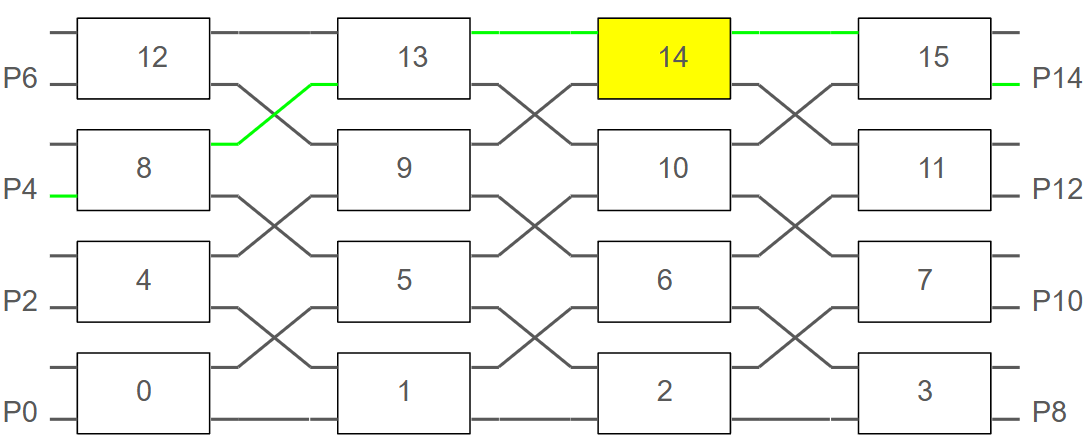



Loading cached simulation from .tidy3d/pf_cache/HGQ/fdtd_info-7OV4PUG2WKRZARKXLW6DJ73PKBND4ZVTYFYA33ZHVU7FJQI3ZZLA.json.
Loading cached simulation from .tidy3d/pf_cache/5FR/fdtd_info-XADWKIBFIMQZYW6INXD5BR4R2YY3XRII7LMJ4PPOFS2BQZ5J5DMQ.json.


Progress: 100% 


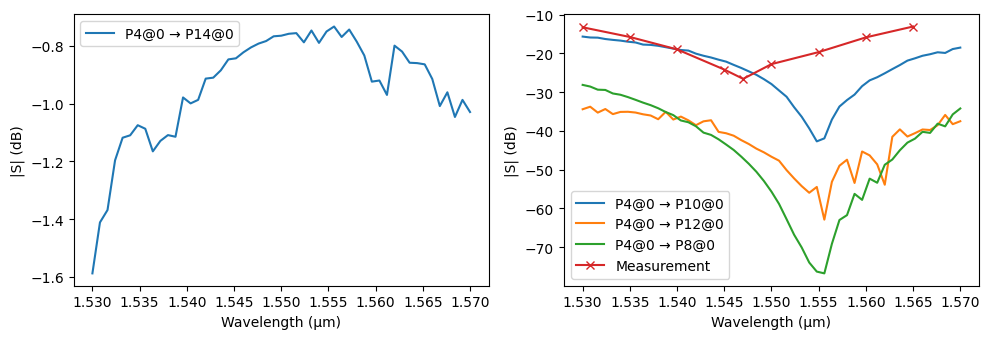

In [15]:
updates = {
    ("Unit Cell", 14, "Tunable MZI", 0, "Phase Shifter", 0): {
        "model_updates": {"n_complex": index(v_bar)}  # Bar state
    }
}

# Compute the S-matrix of the full circuit using the updates
s_matrix = switch_array.s_matrix(
    pf.C_0 / wavelengths, model_kwargs={"updates": updates}
)

# Plot transmission from input port P4 to output ports
fig, ax = pf.plot_s_matrix(
    s_matrix, input_ports=["P4"], output_ports=["P8", "P10", "P12", "P14"], y="dB"
)

# Measures data
wavelengths_m = [1.530, 1.535, 1.540, 1.545, 1.547, 1.550, 1.555, 1.560, 1.565]
crosstalk_m = [-13.3, -15.8, -19.0, -24.2, -26.6, -22.8, -19.7, -15.9, -13.1]

# Plot the measured crosstalk values vs. wavelength
ax[1].plot(wavelengths_m, crosstalk_m, "x-", label="Measurement")
ax[1].legend()

In another configuration, we apply a control voltage to **Unit Cell 10** (highlighted in yellow) to drive its MZI into the **bar state**. As shown in the figure below, this setting redirects the signal from **input port P0** to **output port P10**, following the green-highlighted optical path.

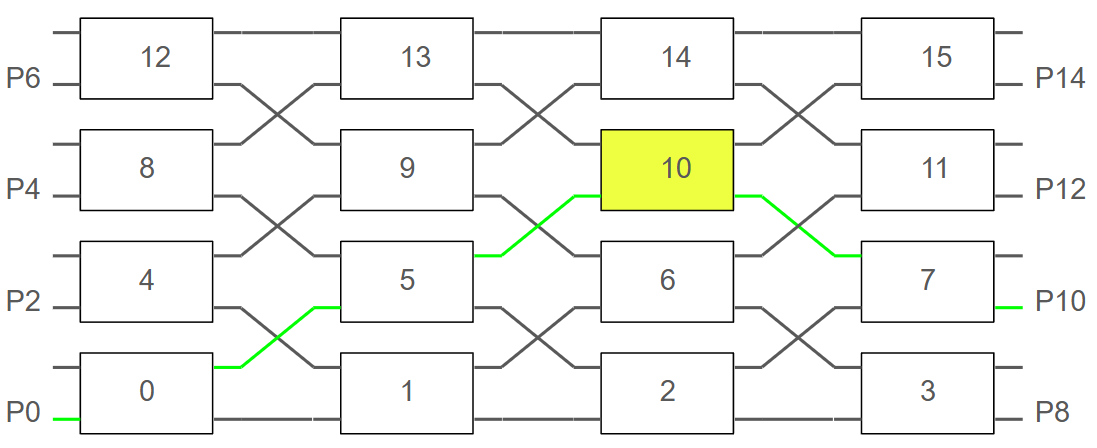


Progress: 100% 


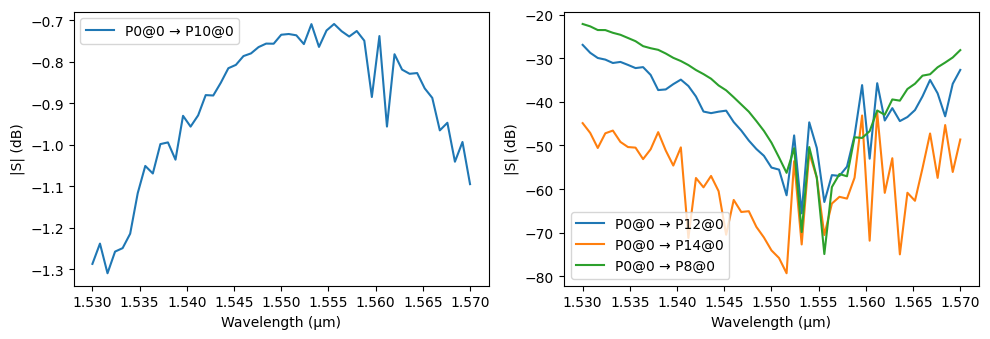

In [16]:
updates = {
    ("Unit Cell", 10, "Tunable MZI", 0, "Phase Shifter", 0): {
        "model_updates": {"n_complex": index(v_bar)}  # Bar state
    }
}

# Compute the S-matrix of the full circuit using the updates
s_matrix = switch_array.s_matrix(
    pf.C_0 / wavelengths, model_kwargs={"updates": updates}
)

# Plot transmission from P0 to the output ports
fig, ax = pf.plot_s_matrix(
    s_matrix, input_ports=["P0"], output_ports=["P8", "P10", "P12", "P14"], y="dB"
)